<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Setup
Let's begin by installing and importing the modules we'll need.

In [1]:
#!pip install -q --upgrade pyro-ppl torch
import pyro
import torch
import pyro.distributions as dist

assert pyro.__version__.startswith('1.8.1')

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


# Icecream Shop

In this self study session, you will be modeling the sales in an ice cream shop. Below you will find an initial specification, and in the following sections you should elaborate on this initial specificaton.

The basis for our model is that 
* We **record the ice-cream sales and the average temperature of the day** (using a temperature sensor).

* We know **temperature affects the sales** of ice-creams.

* We want to **precisely model** how temperature affects ice-cream sales.

<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/Ice-cream_shop_-_Florida.jpg" alt="Drawing" width=300 >
</center>

Note that the model given below is a extension of the temperature model that we explored during the last lecture.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


## Model specification

* We have **observations** from temperature and sales:
>- The relation between the daily temperature $t_i$ and the measured temperature $s_{t,i}$ will be modeled with a Normal distribution as in the last lecture. 
* Daily sales $s_i$ are modeled with a <a href="https://en.wikipedia.org/wiki/Poisson_distribution">Poisson distribution</a>, which expresses the probability of a given number of sales per day based on a so-called rate parameter (the mean and variance of the Poisson distribution is also equal to the rate parameeter):
>- We assume that the rate of the Poisson distribution **linearly depends of the real temperature**.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model.png?raw=1" alt="Drawing" width=700>
</center>



### Data

In [2]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.])}

### Pyro specification of the ice-cream model

In [3]:
def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))

    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

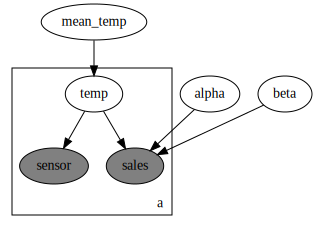

In [4]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


## Auxiliary functions needed for inference and learning
Like in the last lecture we also need an some auxiliary functions to take care of inference. We haven't disucsssed the details of these yet, so just skim this part for now.

In [6]:
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))  

In [7]:
from torch.distributions import constraints
from pyro.optim import SGD
from pyro.infer import Trace_ELBO
import matplotlib.pyplot as plt
from pyro.contrib.autoguide import AutoDiagonalNormal


def svi(temperature_model, obs, guide=None, num_steps = 5000, plot = False, verbose=True):
    pyro.clear_param_store()
    
    if guide is None:
        guide = AutoDiagonalNormal(model)
    
    svi = pyro.infer.SVI(model=temperature_model,
                         guide=guide,
                         optim=SGD({"lr": 0.001, "momentum":0.1}),
                         loss=Trace_ELBO())

    losses, a,b  = [], [], []
    
    for t in range(num_steps):
        losses.append(svi.step(obs))
        if t%250==0:
            print('Step: '+str(t)+'. Loss: ' +str(losses[-1]))
            

    if (plot):
        plt.plot(losses)
        plt.title("ELBO")
        plt.xlabel("step")
        plt.ylabel("loss");
        plt.show()
        
    if verbose:
        print("Inference results:")
        for name, value in pyro.get_param_store().items():
            print(name, pyro.param(name))

## Learning and inference

Let's take our model out for a test run

In [8]:
#Run inference
svi(model, obs, guide, num_steps=1000, verbose=False)

#Print results    
print("Posterior temperature mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))

Step: 0. Loss: 82.11070036888123
Step: 250. Loss: 63.166088700294495
Step: 500. Loss: 65.94465756416321
Step: 750. Loss: 62.750487327575684
Posterior temperature mean
Normal(loc: 19.323291778564453, scale: 0.6266492009162903)

Posterior alpha
Normal(loc: 19.772611618041992, scale: 1.7659878730773926)

Posterior beta
Normal(loc: 1.494997501373291, scale: 0.11826982349157333)


<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 1: Analyze the model above </span> 
* Consider the model specification together with the posterior distributions over the model parameters. Do the these distributions appear reasonabale to you considering the model and the data that you have supplied?

- The model seems overall sensible
- Assumming that the temperature is from a gaussian N(15,2) is sensible
- and having a sensor which measures it with some variance (temp, 1.0) is also sensible
- Modeling number of item sales with Poisson also makes sense
- and the Poisson rate is modeled as linear function of alpha + beta * temp, to estimate average number of sales per day
- Also having the constraints on the scales of the alpha and beta makes to avoid negative number of sales

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


### <span style="color:red">Exercise 2: Introduce Humidity in the Icecream shop model </span> 

In this exercise you should extend the model above to also account for the daily humidity $h_i$:
* Assume we also have a bunch of daily humidity sensor measurements $s_{h,i}$.
* Assume the **sales are also linearly influenced by the humidity**.

Extend the model above in order to integrate these new pieces of information.

The figure below gives a formal description of the model:
<center>
<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/Ice-Cream-Shop-Model-Humidity.png?raw=1" alt="Drawing" width=1000>
</center>




In [17]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}


def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random variable "mean_humidity"
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(80.0, 5.0))
    
    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    
    ## Introduce a coefficient for the humidity "gamma"
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))


    with pyro.plate('a', obs['sensor'].shape[0]):
        temp = pyro.sample('temp', dist.Normal(mean_temp, 2.0))
        sensor = pyro.sample('sensor', dist.Normal(temp, 1.0), obs=obs['sensor'])
        #Add the 'humidity' variable and the 'sensor_humidity' variable
        humidity = pyro.sample('humidity', dist.Normal(mean_humidity, 2.0))
        sensor_humidity = pyro.sample('sensor_humidity', dist.Normal(humidity, 1.0), obs=obs['sensor_humidity'])
       
        #Add the linear dependency for the rate with respect to temp and humidity
        rate = torch.max(torch.tensor(0.001), alpha + beta*temp + gamma*humidity)
        sales = pyro.sample('sales', dist.Poisson(rate), obs=obs['sales'])

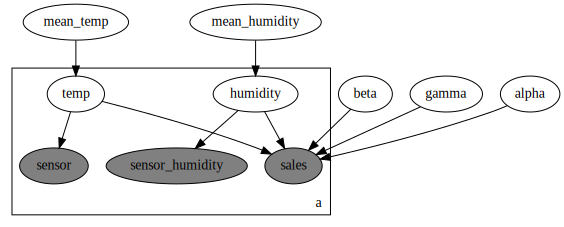

In [18]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again we need a guide for performing inference (you need not worry about the details of this part)

In [19]:
#@title
#Auxiliary Guide Code
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    meanH = pyro.param("meanH", torch.mean(obs['sensor_humidity']))
    scaleH = pyro.param("scaleH", torch.tensor(1.), constraint=constraints.positive)
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(meanH, scaleH))


    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']), constraint=constraints.positive)
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.positive)
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(1.0), constraint=constraints.positive)
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.positive)
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    gamma_mean = pyro.param("gamma_mean", torch.tensor(1.0), constraint=constraints.positive)
    gamma_scale = pyro.param("gamma_scale", torch.tensor(1.), constraint=constraints.positive)
    gamma = pyro.sample('gamma', dist.Normal(gamma_mean, gamma_scale))

    with pyro.plate('a', obs['sensor'].shape[0]) as i:
        mean_i = pyro.param('mean_i', obs['sensor'][i])
        scale_i = pyro.param('scale_i', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample('temp', dist.Normal(mean_i, scale_i))
        meanH_i = pyro.param('meanH_i', obs['sensor_humidity'][i])
        scaleH_i = pyro.param('scaleH_i', torch.tensor(1.), constraint=constraints.positive)
        humidity = pyro.sample('humidity', dist.Normal(meanH_i, scaleH_i)) 

In [23]:
#Run inference
svi(model, obs, guide, num_steps=1000)

#Print results    
print("Posterior Temperature Mean")
print(dist.Normal(pyro.param("mean").item(), pyro.param("scale").item()))
print("")
print("Posterior Humidity Mean")
print(dist.Normal(pyro.param("meanH").item(), pyro.param("scaleH").item()))
print("")
print("Posterior Alpha")
print(dist.Normal(pyro.param("alpha_mean").item(), pyro.param("alpha_scale").item()))
print("")
print("Posterior Beta")
print(dist.Normal(pyro.param("beta_mean").item(), pyro.param("beta_scale").item()))
print("")
print("Posterior Gamma")
print(dist.Normal(pyro.param("gamma_mean").item(), pyro.param("gamma_scale").item()))

Step: 0. Loss: 1420.3366702795029
Step: 250. Loss: 191.3543091416359
Step: 500. Loss: 175.9045548439026
Step: 750. Loss: 174.77376246452332
Inference results:
mean tensor(19.3397, requires_grad=True)
scale tensor(0.6297, grad_fn=<AddBackward0>)
meanH tensor(86.2784, requires_grad=True)
scaleH tensor(0.6649, grad_fn=<AddBackward0>)
alpha_mean tensor(15.4032, grad_fn=<AddBackward0>)
alpha_scale tensor(1.7873, grad_fn=<AddBackward0>)
beta_mean tensor(0.8754, grad_fn=<AddBackward0>)
beta_scale tensor(0.1214, grad_fn=<AddBackward0>)
gamma_mean tensor(0.2076, grad_fn=<AddBackward0>)
gamma_scale tensor(0.0280, grad_fn=<AddBackward0>)
mean_i tensor([18.1698, 18.7732, 19.2651, 18.0022, 20.1674, 21.9185, 20.1465, 20.9198,
        19.4845, 20.0008], requires_grad=True)
scale_i tensor(0.8885, grad_fn=<AddBackward0>)
meanH_i tensor([83.3166, 87.4581, 71.6748, 76.0209, 81.1589, 93.0026, 90.4923, 91.3242,
        97.1718, 92.2131], requires_grad=True)
scaleH_i tensor(0.9052, grad_fn=<AddBackward0>)
P

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

# 5.  **Temporal Models**

If we expect that there might a temporal dependency between the variables, we can capture this in the model specification.

Let us assume that there is a **temporal dependency** between the variables.

* E.g. the current real temperature must be similar to the real temperature in the previous time step.

This temporal dependency can be modeled using a **for-loop** in Pyro as illustrated in the graphical representation.


<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/tempmodel-temporal-III.png" alt="Drawing" style="width: 350px;" >


Observe how this temporal model shares commonalities with the temporal models that we discussed a couple of lectures a go. 

In [24]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1])}

def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        prev_temp = temp

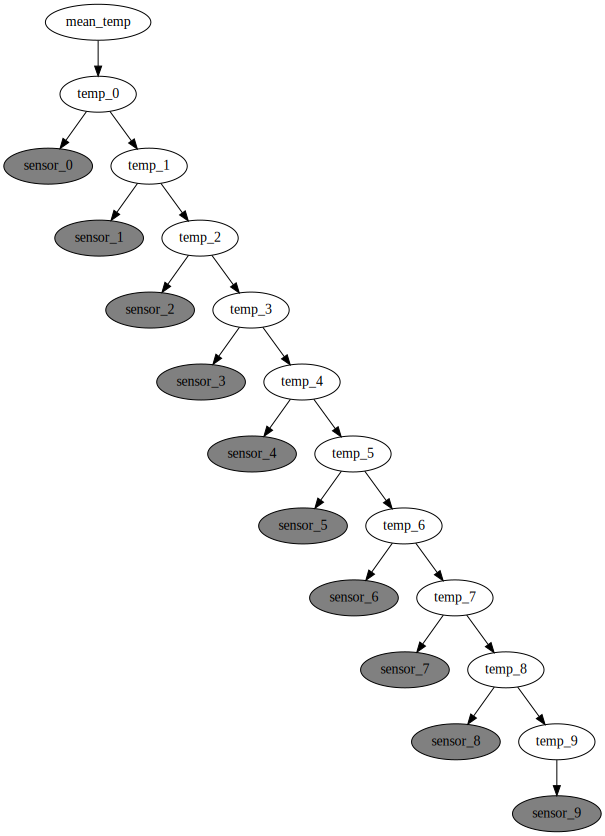

In [25]:
#Visualize the model
pyro.render_model(model, model_args=(obs, ))

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again we need a guide for performing inference (you need not worry about the details of this part)

In [26]:
#@title
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.positive)
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))
    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.positive)
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))

In [27]:
import time
        
#Run inference
svi(model, obs, guide=guide, num_steps=1000)

smooth_temp=[]
for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f'mean_{i}').item())

print('Finished')

Step: 0. Loss: 24.13700520992279
Step: 250. Loss: 26.63866353034973
Step: 500. Loss: 20.861225366592407
Step: 750. Loss: 20.343696296215057
Inference results:
mean tensor(18.4136, requires_grad=True)
scale tensor(1.3582, grad_fn=<AddBackward0>)
mean_0 tensor(18.2928, requires_grad=True)
scale_0 tensor(0.8303, grad_fn=<AddBackward0>)
mean_1 tensor(18.6581, requires_grad=True)
scale_1 tensor(0.8583, grad_fn=<AddBackward0>)
mean_2 tensor(18.8730, requires_grad=True)
scale_2 tensor(0.8288, grad_fn=<AddBackward0>)
mean_3 tensor(18.6393, requires_grad=True)
scale_3 tensor(0.8673, grad_fn=<AddBackward0>)
mean_4 tensor(20.1886, requires_grad=True)
scale_4 tensor(0.8226, grad_fn=<AddBackward0>)
mean_5 tensor(21.5540, requires_grad=True)
scale_5 tensor(0.8480, grad_fn=<AddBackward0>)
mean_6 tensor(20.7893, requires_grad=True)
scale_6 tensor(0.8579, grad_fn=<AddBackward0>)
mean_7 tensor(20.7697, requires_grad=True)
scale_7 tensor(0.8130, grad_fn=<AddBackward0>)
mean_8 tensor(19.9498, requires_gra

We can now plot the **observered measurements** of the temperature **against** the inferred **real temperature**.

* By querying the **local hidden** we can **smooth** the temperature.

* The **recovered temperature** is much less noisy than the measured one. 

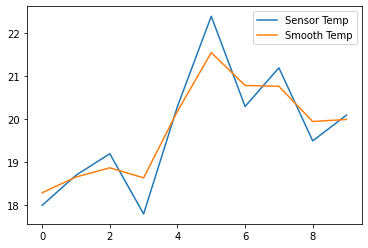

In [28]:
import matplotlib.pyplot as plt
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

### <span style="color:red">Exercise 3:  Temporal Extension of the Iceacream shop model </span> 

Assume that:
* temperature depends of the **temperature in the previous day**.
* humidity depends of the **humidity in the previous day**.
* sales depends on the **current temperature and humidity**.

Use the following **graphical representation for reference**.

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day1/Figures/icecream-model-temporal.png" alt="Drawing" width=800 >

Note that the plate representation has to be coded in Pyro using a **``for-loop``**.

In [29]:
#The observatons   
obs = {'sensor': torch.tensor([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1]),
       'sales': torch.tensor([46., 47., 49., 44., 50., 54., 51., 52., 49., 53.]),
       'sensor_humidity': torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])}



def model(obs):
    mean_temp = pyro.sample('mean_temp', dist.Normal(15.0, 2.0))
    ## Introduce a random variable "mean_humidity"
    mean_humidity = pyro.sample('mean_humidity', dist.Normal(80.0, 5.0))


    alpha = pyro.sample('alpha', dist.Normal(0.0, 100.0))
    beta = pyro.sample('beta', dist.Normal(0.0, 100.0))
    ## Introduce a coefficient for the humidity "gamma"
    gamma = pyro.sample('gamma', dist.Normal(0.0, 100.0))
    
    for i in range(obs['sensor'].shape[0]):
        if i==0:
            temp = pyro.sample(f'temp_{i}', dist.Normal(mean_temp, 2.0))
            #Introduce the 'humidity' variable at time 0.
            humidity = pyro.sample(f'humidity_{i}', dist.Normal(mean_humidity, 2.0))
        else:
            temp = pyro.sample(f'temp_{i}', dist.Normal(prev_temp, 2.0))
            #Introduce the f'humidity_{i}' variable defining the transition
            humidity = pyro.sample(f'humidity_{i}', dist.Normal(prev_humidity, 2.0))
            
        sensor = pyro.sample(f'sensor_{i}', dist.Normal(temp, 1.0), obs=obs['sensor'][i])
        #Introduce the f'sensor_humidity_{i}' variable. 
        sensor_hummidity = pyro.sample(f'sensor_humidity_{i}', dist.Normal(humidity, 1.0), obs=obs['sensor_humidity'][i])
        
        #Add the linear dependency for the rate with respect to temp and humidity (keep torch.max to avoid numerical stability issues)
        rate = torch.max(alpha + beta * temp + gamma * sensor_hummidity, torch.tensor(0.001))
        sales = pyro.sample(f'sales_{i}', dist.Poisson(rate), obs=obs['sales'][i])

        prev_temp = temp
        #Keep humidity for the next time step. 
        prev_humidity = humidity

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>


Again we need a guide for performing inference (you need not worry about the details of this part)

In [30]:
#@title
#Define the guide
def guide(obs):
    mean = pyro.param("mean", torch.mean(obs['sensor']))
    scale = pyro.param("scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    mean_temp = pyro.sample('mean_temp', dist.Normal(mean, scale))

    meanH = pyro.param("meanH", torch.mean(obs['sensor_humidity']), constraint=constraints.positive)
    scaleH = pyro.param("scaleH", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    humidity_mean = pyro.sample('mean_humidity', dist.Normal(meanH, scaleH))


    alpha_mean = pyro.param("alpha_mean", torch.mean(obs['sensor']))
    alpha_scale = pyro.param("alpha_scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    alpha = pyro.sample('alpha', dist.Normal(alpha_mean, alpha_scale))

    beta_mean = pyro.param("beta_mean", torch.tensor(0.0))
    beta_scale = pyro.param("beta_scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    beta = pyro.sample('beta', dist.Normal(beta_mean, beta_scale))

    gamma_mean = pyro.param("gamma_mean", torch.tensor(0.0))
    gamma_scale = pyro.param("gamma_scale", torch.tensor(1.), constraint=constraints.greater_than(0.01))
    gamma = pyro.sample('gamma', dist.Normal(gamma_mean, gamma_scale))

    for i in range(obs['sensor'].shape[0]):
        mean_i = pyro.param(f'mean_{i}', obs['sensor'][i])
        scale_i = pyro.param(f'scale_{i}', torch.tensor(1.), constraint=constraints.greater_than(0.01))
        temp = pyro.sample(f'temp_{i}', dist.Normal(mean_i, scale_i))
        meanH_i = pyro.param(f'meanH_{i}', obs['sensor_humidity'][i])
        scaleH_i = pyro.param(f'scaleH_{i}', torch.tensor(1.), constraint=constraints.greater_than(0.01))
        humidity_i = pyro.sample(f'humidity_{i}', dist.Normal(meanH_i, scaleH_i))

In [36]:
import time
        
#Run inference
svi(model, obs, guide, num_steps=2000)

smooth_temp=[]
smooth_humidity=[]

for i in range(obs['sensor'].shape[0]):
    smooth_temp.append(pyro.param(f'mean_{i}').item())
    smooth_humidity.append(pyro.param(f'meanH_{i}').item())

print('Finished')

Step: 0. Loss: 4955.023304581642
Step: 250. Loss: 114.81853944063187
Step: 500. Loss: 100.41937363147736
Step: 750. Loss: 101.31079179048538
Step: 1000. Loss: 99.81814551353455
Step: 1250. Loss: 100.04778707027435
Step: 1500. Loss: 97.29174619913101
Step: 1750. Loss: 100.40447497367859
Inference results:
mean tensor(17.6911, requires_grad=True)
scale tensor(1.4001, grad_fn=<AddBackward0>)
meanH tensor(80.9880, grad_fn=<AddBackward0>)
scaleH tensor(1.9616, grad_fn=<AddBackward0>)
alpha_mean tensor(19.7109, requires_grad=True)
alpha_scale tensor(1.9394, grad_fn=<AddBackward0>)
beta_mean tensor(0.2934, requires_grad=True)
beta_scale tensor(0.1106, grad_fn=<AddBackward0>)
gamma_mean tensor(0.2429, requires_grad=True)
gamma_scale tensor(0.0287, grad_fn=<AddBackward0>)
mean_0 tensor(18.3567, requires_grad=True)
scale_0 tensor(0.7951, grad_fn=<AddBackward0>)
meanH_0 tensor(81.6382, requires_grad=True)
scaleH_0 tensor(0.8267, grad_fn=<AddBackward0>)
mean_1 tensor(18.5017, requires_grad=True)
s

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>

Again, we can plot the observered measurements of the temperature against the **inferred real temperature** by our model. The **recovered temperature** is much less noisy than the real one.

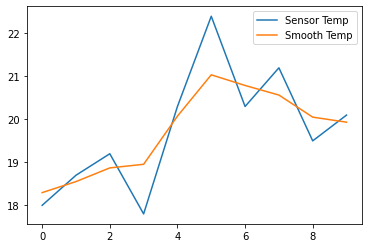

In [32]:
plt.plot([18., 18.7, 19.2, 17.8, 20.3, 22.4, 20.3, 21.2, 19.5, 20.1], label='Sensor Temp')
plt.plot(smooth_temp, label='Smooth Temp')
plt.legend()

We can also plot the observered measurements of the humidity against the **inferred real humidity** by our model. The **recovered humidity** is much less noisy than the real one.

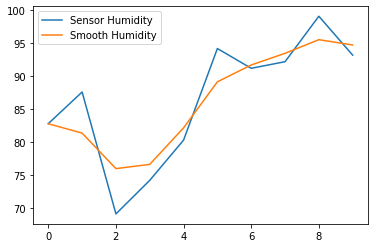

In [33]:
humidity = torch.tensor([82.8, 87.6, 69.1, 74.2, 80.3, 94.2, 91.2, 92.2, 99.1, 93.2])
plt.plot(humidity.detach().numpy(), label='Sensor Humidity')
plt.plot(smooth_humidity, label='Smooth Humidity')
plt.legend()

<img src="https://github.com/PGM-Lab/probai-2021-pyro/blob/main/Day1/Figures/blue.png?raw=1" alt="Drawing" width=2000 height=20>
